# Classificador de poemas do Fernando Pessoa
## Grupo Turing - NLP

## Passo 0: importando as bibliotecas

In [12]:
import re
import unicodedata

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PortugueseStemmer
from langdetect import detect, DetectorFactory
import spacy

In [13]:
nltk.download('stopwords')
tqdm.pandas()
DetectorFactory.seed = 42

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Passo 1: carregar o dataset e filtrar por autores mais frequentes

In [35]:
dados = pd.read_csv('fernando_pessoa.csv')
dados.drop(['id', 'titulo', 'data', 'bibliografia'], inplace=True, axis=1)
dados.reset_index(drop=True, inplace=True)

Nesse passo, optamos por trabalhar com os autores com mais de 80 textos, pois menos que isso poderia ocasionar um sobreajuste. 

In [15]:
dados = dados.groupby('autor').filter(lambda x : (x['autor'].count()>=80).any())

Além disso, percebemos que no corpus há muitos textos em inglês, para isso utilizamos a função **detect** da biblioteca *langdetect*. Isso eliminou certa de 625 textos.

In [16]:
dados['port'] = dados['texto'].progress_apply(lambda x: detect(x) != 'en')
dados = dados[dados['port'] == True]
dados.reset_index(inplace = True)

100%|██████████████████████████████████████████████████████████████████████████████| 4383/4383 [01:37<00:00, 44.91it/s]


## Passo 2: Preprocessamento: stemização, lematização, etc. 

Ao analisar os textos, vimos que muitas palavras começavam com um travessão ou *underscore* indicador de diálogo. Para resolver tal problema, criamos a função `remover_underscore`, que lidou bem com o problema. 

In [17]:
def remover_underscore(palavra):
    if palavra[0] == '_' or palavra[-1] == '_':
        return palavra.replace('_', '')
    else:
        return palavra

Também percebemos que palavras acentuados prejudicam o modelo de stemização e de lematização, portanto optamos por remover todos os acentos. A função `remover_acento` talvez poderia ser mais simples, entretanto foi a solução encontrada. 

In [18]:
def remover_acento(texto):
    try:
        texto = unicode(texto, 'utf-8')
    except NameError:
        pass
    texto = unicodedata.normalize('NFD', texto)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    return str(texto)

Por último, tanto na stemização, quanto na lematização, foi importante remover _stopwords_ do texto. Para isso, usaremos a lista de stopwords em português que o NLTK fornece. Além disso, também usamos expressões regulares (*regex*) para eliminar quaisquer caracteres que pudessem poluir o texto.

In [19]:
stopwords_pt = set(stopwords.words('portuguese'))

def remover_stopwords(texto, lista=False):
    palavras = re.findall(r'\b[A-zÀ-úü]+\b', texto.lower())
    sem_stopwords = [p for p in palavras if p not in stopwords_pt]
    if lista:
        return sem_stopwords
    else:
        return ' '.join(sem_stopwords)

### Passo 2.1: stemização utilizando SnowBall

Aqui criamos as duas funções mais importantes do preprocessamento do texto. A primeira, `stemizar`, recebe o texto não processado e o devolve com as palavras stemizadas e sem stopwords. Para isso, utilizamos o algoritmo *Snowball* criado por Martin Porter. A biblioteca do NLTK conta com um stemizador chamado `PortugueseStemmer` e é ele que utilizaremos.

In [20]:
def stemizar(texto_original):
    palavras_importantes = remover_stopwords(texto_original, lista=True)
    
    stemizador = PortugueseStemmer()
    palavras = []

    for p in palavras_importantes:
        novo_p = remover_underscore(remover_acento(p))
        palavras.append(stemizador.stem(novo_p))
    return ' '.join(palavras)

### Passo 2.2: lematização utilizando spaCy

A outra função criada foi a `lematizar`. Similar à função anterior, essa função recebe o texto não processado e o devolve com os verbos lematizados. Para isso, utilizamos os modelos da biblioteca **spaCy**, a qual conta também com ferramentas de marcação de partes do discurso, utilizadas na função para separar os verbos a serem lematizados. 

In [21]:
nlp = spacy.load('pt_core_news_sm')

def lematizar(texto_original):
    palavras_importantes = remover_stopwords(texto_original, lista=True)
    
    texto_importante = ' '.join(palavras_importantes)
    texto_importante = remover_underscore(remover_acento(texto_importante))
    
    doc = nlp(texto_importante)
    doc_lematizado = [token.lemma_ if token.pos_ == 'VERB' else str(token) for token in doc]
    return ' '.join(doc_lematizado)

Finalmente, aplicamos as duas funções ao corpus, gerando as colunas *texto_stemizado*, *texto_lematizado*, *texto_sem_stopwords* e *texto_l_s* (combinação de lematização e stemização).

In [22]:
dados['texto_stemizado'] = dados.texto.progress_apply(stemizar)
dados['texto_lematizado'] = dados.texto.progress_apply(lematizar)
dados['texto_l_s'] = dados.texto.progress_apply(lambda x: stemizar(lematizar(x)))
dados['texto_sem_stopwords'] = dados.texto.progress_apply(remover_stopwords)

100%|████████████████████████████████████████████████████████████████████████████| 3759/3759 [00:00<00:00, 4769.11it/s]


In [23]:
dados.head()

,index,autor,tipo,texto,port,texto_stemizado,texto_lematizado,texto_l_s,texto_sem_stopwords
0,0,Ricardo Reis,poesia,Diana através dos ramos\nEspreita a vinda de E...,True,dian atrav ram espreit vind endymion endymion ...,diana atraves ramos espreitar vir endymion end...,dian atrav ram espreit vir endymion endymion n...,diana através ramos espreita vinda endymion en...
1,1,Fernando Pessoa,prosa,A REFORMA DO CALENDÁRIO E AS SUAS CONSEQUÊNCIA...,True,reform calendari consequenc comerc comissa esp...,reforma calendario consequencias comerciais co...,reform calendari consequenc comerc comissa esp...,reforma calendário consequências comerciais co...
2,3,Ricardo Reis,poesia,"Aqui, sem outro Apolo do que Apolo,\nSem um su...",True,aqu outr apol apol suspir abandon crist febr b...,aqui outro apolo apolo suspiro abandonemos cri...,aqu outr apol apol suspir abandon crist febr b...,aqui outro apolo apolo suspiro abandonemos cri...
3,5,Ricardo Reis,poesia,Em Ceres anoitece.\nNos píncaros ainda\nFaz lu...,True,cer anoitec pincar aind faz luz sint tao grand...,ceres anoitecer pincaros ainda fazer luz sinto...,cer anoitec pincar aind faz luz sint tao grand...,ceres anoitece píncaros ainda faz luz sinto tã...
4,8,Ricardo Reis,poesia,"Não a ti, mas aos teus, odeio, Cristo.\nTu não...",True,ti odei crist es deus etern panteon presid vid...,ti odeio cristo es deus eterno panteon preside...,ti odei crist es deus etern panteon presid vid...,ti odeio cristo és deus eterno pantéon preside...


## Passo 3: criação do modelo

Para treinamento do modelo, optamos por utilizar os 4 heterônimos com mais textos (Bernardo Soares, Álvaro de Campos, Ricardo Reis e Alberto Caeiro). Os textos classificados como Fernando Pessoa serão utilizados para treinar o modelo de *tf-idf*, mas não serão utilizados para treinar os modelos de classificaçã.

In [24]:
dados.autor.value_counts()

Fernando Pessoa     2327
Bernardo Soares      503
Álvaro de Campos     393
Ricardo Reis         307
Alberto Caeiro       127
António Mora          95
Alexander Search       7
Name: autor, dtype: int64

Criamos então o DataFrame `autores_principais`, o qual contém os quatro heterônimos mais frequentes.

In [25]:
autores_principais = ['Bernardo Soares', 'Álvaro de Campos', 'Ricardo Reis', 'Alberto Caeiro']
dados_principais = dados[dados['autor'].isin(autores_principais)].copy()
dados_principais.autor.value_counts()

Bernardo Soares     503
Álvaro de Campos    393
Ricardo Reis        307
Alberto Caeiro      127
Name: autor, dtype: int64

### Passo 3.1: codificação dos autores

Para podermos montar um modelo classificatório, precisamos lidar com a coluna categórica *author* do DataFrame. O `LabelEncoder` do **scikit-learn** é capaz de lidar com o problema. 

In [26]:
le = LabelEncoder()
dados_principais['autor_codificado'] = le.fit_transform(dados_principais['autor'])

In [27]:
dados_principais.head()

,index,autor,tipo,texto,port,texto_stemizado,texto_lematizado,texto_l_s,texto_sem_stopwords,autor_codificado
0,0,Ricardo Reis,poesia,Diana através dos ramos\nEspreita a vinda de E...,True,dian atrav ram espreit vind endymion endymion ...,diana atraves ramos espreitar vir endymion end...,dian atrav ram espreit vir endymion endymion n...,diana através ramos espreita vinda endymion en...,2
2,3,Ricardo Reis,poesia,"Aqui, sem outro Apolo do que Apolo,\nSem um su...",True,aqu outr apol apol suspir abandon crist febr b...,aqui outro apolo apolo suspiro abandonemos cri...,aqu outr apol apol suspir abandon crist febr b...,aqui outro apolo apolo suspiro abandonemos cri...,2
3,5,Ricardo Reis,poesia,Em Ceres anoitece.\nNos píncaros ainda\nFaz lu...,True,cer anoitec pincar aind faz luz sint tao grand...,ceres anoitecer pincaros ainda fazer luz sinto...,cer anoitec pincar aind faz luz sint tao grand...,ceres anoitece píncaros ainda faz luz sinto tã...,2
4,8,Ricardo Reis,poesia,"Não a ti, mas aos teus, odeio, Cristo.\nTu não...",True,ti odei crist es deus etern panteon presid vid...,ti odeio cristo es deus eterno panteon preside...,ti odei crist es deus etern panteon presid vid...,ti odeio cristo és deus eterno pantéon preside...,2
6,10,Bernardo Soares,prosa,— A única vantagem de estudar é gozar o quanto...,True,unic vantag estud goz quant outr diss arte iso...,unica vantagem estudar gozar quanto outros diz...,unic vantag estud goz quant outr diz arte isol...,única vantagem estudar gozar quanto outros dis...,1


### Passo 3.2: divisão do DataFrame em treino e teste

Para essa tarefa, utilizamos `train_test_split`, com o DataFrame de teste contendo 10% do conteúdo do DataFrame original.

In [28]:
train_X, test_X, train_Y, test_Y = train_test_split(
    dados_principais[['texto', 'texto_stemizado', 'texto_sem_stopwords', 'texto_l_s', 'texto_lematizado']],
    dados_principais['autor_codificado'],
    test_size = 0.1,
    random_state = 42,
)

### Passo 3.3: criação do tf-idf

Para criação do vetor do *tf-idf* utilizamos o texto lematizado e depois stemizados de **todos** autores. Depois aplicamos a transformação aprendida em todo o corpus nos DataFrames de teste e treino.

In [29]:
tfidf_vector = TfidfVectorizer()
tfidf_vector.fit(dados_principais['texto_l_s'])

train_X_tfidf = tfidf_vector.transform(train_X['texto_l_s'])
test_X_tfidf = tfidf_vector.transform(test_X['texto_l_s'])

dados_principais_tfidf = tfidf_vector.transform(dados_principais['texto_l_s'])

### Passo 3.4: aplicando modelos

Nesse notebook, optamos por utilizar dois modelos clássicos para classificação de texto utilizando *tf-idf*: *Gaussian Naive Bayes* e *Support Vector Machine*. Uma explicação detalhada dos modelos pode ser encontrada na nossa página do Medium: [Turing Talks](https://medium.com/turing-talks).

#### 3.4.1 GaussianNaiveBayes

In [30]:
nb = GaussianNB()
nb.fit(train_X_tfidf.toarray(), train_Y)
predictions_nb = nb.predict(test_X_tfidf.toarray())
acuracia = accuracy_score(predictions_nb, test_Y)
print(f"Acurácia do Naive Bayes: {acuracia*100:.3f}%")

Acurácia do Naive Bayes: 60.902%


#### 3.4.2 Support Vector Machine

In [31]:
svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm.fit(train_X_tfidf, train_Y)
predictions_svm = svm.predict(test_X_tfidf)
acuracia = accuracy_score(predictions_svm, test_Y)
print(f"Acurácia da SVM: {acuracia*100:.3f}%")

Acurácia da SVM: 82.707%


A SVM obteve resultados muito mais satisfatórios. Além disso, durante os testes, a utilização da coluna *texto_l_s* aumentou em cerca de 8% a acurácia do modelo e por isso ela foi a escolhida para ser utilizada.

## Passo 4: visualizando os vetores do tf-idf utilizando redução de dimensionalidade

Afim de obtermos uma visualização do *tf-idf*, aplicamos a transformação individualmente para cada autor e então reduzimos o vetor a duas dimensões utilizando o algoritmo **PCA**. A utilização de algoritmos mais complexos também se mostrou viável, mas optamos por não colocar suas aplicações nesse notebook.

### Passo 4.1: aplicando *tf-idf* para cada heterônimo 

In [32]:
bernardo = dados_principais[dados_principais.autor == 'Bernardo Soares']
ricardo = dados_principais[dados_principais.autor == 'Ricardo Reis']
campos = dados_principais[dados_principais.autor == 'Álvaro de Campos']
alberto = dados_principais[dados_principais.autor == 'Alberto Caeiro']

bernardo_tfidf = tfidf_vector.transform(bernardo.texto_stemizado)
ricardo_tfidf = tfidf_vector.transform(ricardo.texto_stemizado)
campos_tfidf = tfidf_vector.transform(campos.texto_stemizado)
alberto_tfidf = tfidf_vector.transform(alberto.texto_stemizado)

### Passo 4.2: aplicando PCA nos vetores do *tf-idf* e então utilizando matplotlib para visualizar os resultados

Nesse passo, utlizamos uma simples transformação para duas dimensões e então plotamos o PCA em um scatter do matplotlib.

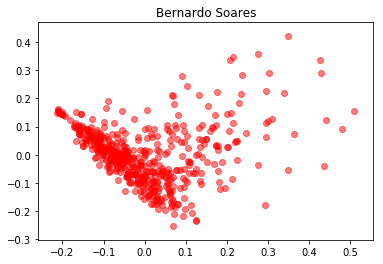

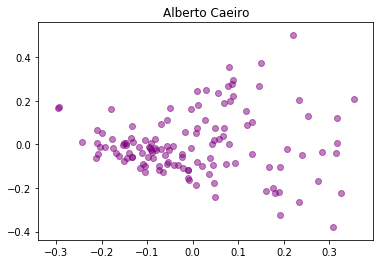

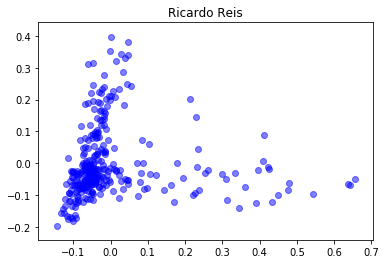

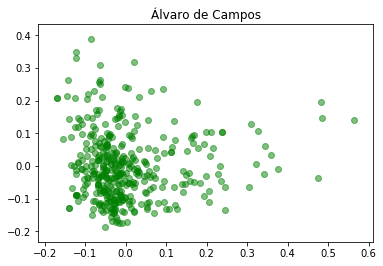

In [33]:
data2D = PCA(n_components = 2).fit_transform(bernardo_tfidf.todense())
plt.scatter(data2D[:, 0], data2D[:, 1], c = 'red', alpha = 0.5)
plt.title('Bernardo Soares')
plt.show()

data2D = PCA(n_components = 2).fit_transform(alberto_tfidf.todense())
plt.scatter(data2D[:, 0], data2D[:, 1], c = 'purple', alpha = 0.5)
plt.title('Alberto Caeiro')
plt.show()

data2D = PCA(n_components = 2).fit_transform(ricardo_tfidf.todense())
plt.scatter(data2D[:, 0], data2D[:, 1], c = 'blue', alpha = 0.5)
plt.title('Ricardo Reis')
plt.show()

data2D = PCA(n_components = 2).fit_transform(campos_tfidf.todense())
plt.scatter(data2D[:, 0], data2D[:, 1], c = 'green', alpha = 0.5)
plt.title('Álvaro de Campos')
plt.show()